In [1]:
# Retail Sales Forecasting System 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import joblib


In [2]:
# --- Load Datasets ---
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train_rows = train.shape[0]
df = pd.concat([train, test], ignore_index=True)
df.reset_index(drop=True, inplace=True)


In [3]:
# --- Data Cleaning ---
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'})

df['Item_Weight'] = df['Item_Weight'].fillna(df.groupby('Item_Identifier')['Item_Weight'].transform('mean'))
df['Item_Weight'].fillna(df['Item_Weight'].mean(), inplace=True)

df['Item_Visibility'] = df['Item_Visibility'].replace(0, np.nan)
df['Item_Visibility'] = df['Item_Visibility'].fillna(df.groupby('Item_Identifier')['Item_Visibility'].transform('mean'))
df['Item_Visibility'].fillna(df['Item_Visibility'].mean(), inplace=True)

CURRENT_YEAR = 2025
df['Outlet_Age'] = CURRENT_YEAR - df['Outlet_Establishment_Year']

df['Outlet_Size'] = df.groupby('Outlet_Type')['Outlet_Size'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Medium'))

df['Price_per_UnitWeight'] = df['Item_MRP'] / df['Item_Weight']
df['Low_Visibility_Flag'] = (df['Item_Visibility'] < df['Item_Visibility'].median()).astype(int)


In [4]:
# --- Split Back ---
train_df = df.iloc[:train_rows, :].copy()
test_df = df.iloc[train_rows:, :].copy()


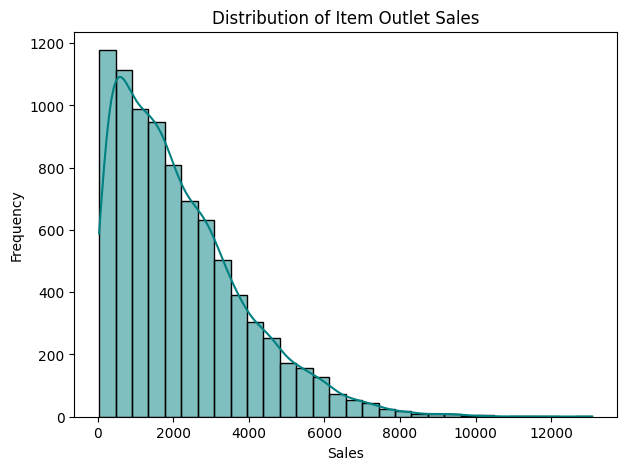

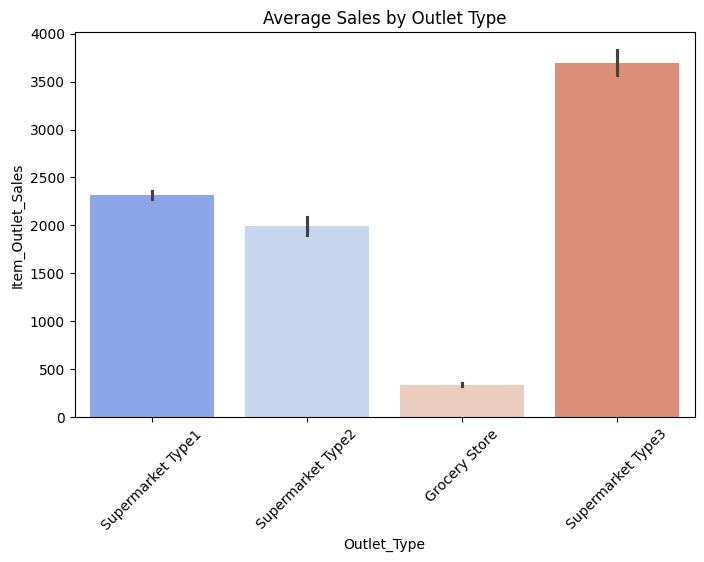

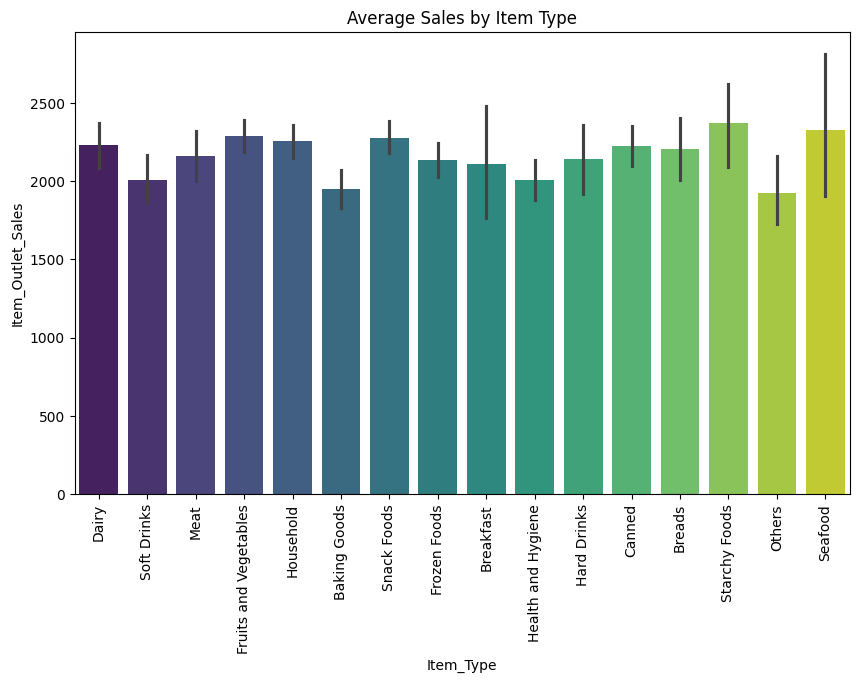

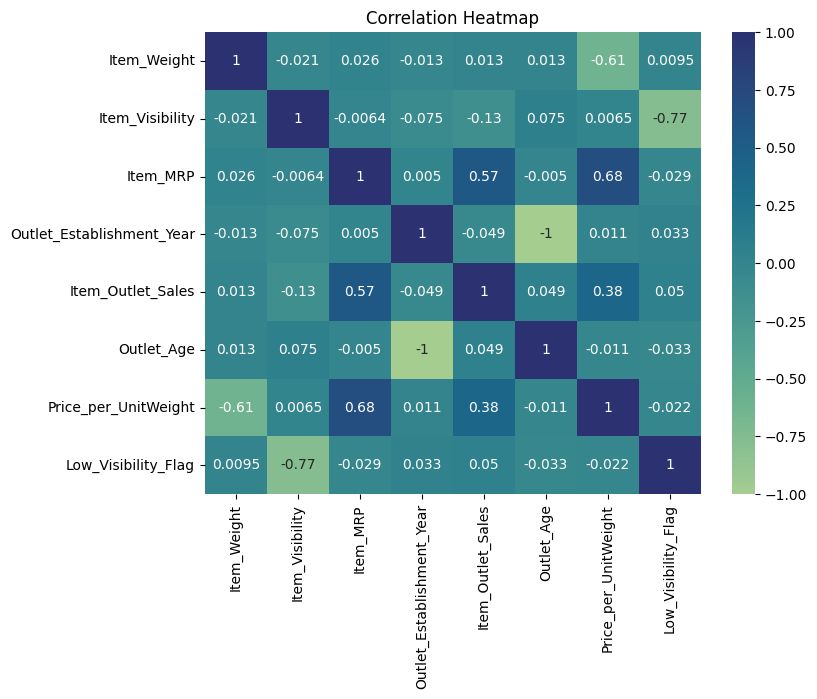

In [5]:
# --- Exploratory Data Analysis ---
plt.figure(figsize=(7,5))
sns.histplot(train_df['Item_Outlet_Sales'], bins=30, kde=True, color='teal')
plt.title('Distribution of Item Outlet Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(x='Outlet_Type', y='Item_Outlet_Sales', data=train_df, estimator='mean', palette='coolwarm')
plt.title('Average Sales by Outlet Type')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x='Item_Type', y='Item_Outlet_Sales', data=train_df, estimator='mean', palette='viridis')
plt.title('Average Sales by Item Type')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(train_df.select_dtypes(include='number').corr(), annot=True, cmap='crest')
plt.title('Correlation Heatmap')
plt.show()

In [6]:
# --- Model Training ---
X = train_df.drop(columns=['Item_Outlet_Sales','Item_Identifier','Outlet_Identifier'])
y = train_df['Item_Outlet_Sales']

numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

rf_model = Pipeline(steps=[('preprocessor', preprocessor), ('model', RandomForestRegressor(n_estimators=150, random_state=42))])
rf_model.fit(X_train, y_train)

def evaluate(model, X_val, y_val):
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    mae = mean_absolute_error(y_val, preds)
    r2 = r2_score(y_val, preds)
    return rmse, mae, r2, preds

rmse, mae, r2, y_val_pred = evaluate(rf_model, X_val, y_val)
print(f'Random Forest Evaluation: RMSE={rmse:.2f}, MAE={mae:.2f}, R2={r2:.2f}')


Random Forest Evaluation: RMSE=1090.51, MAE=756.92, R2=0.56


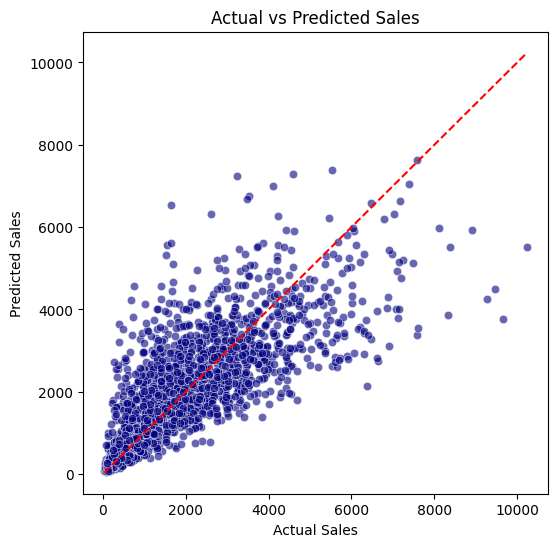

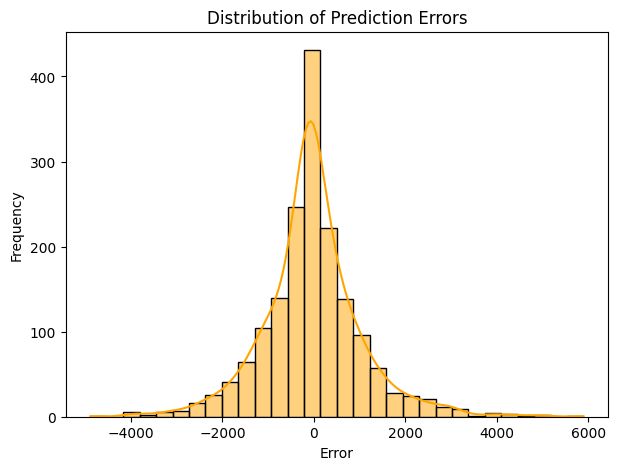

In [7]:
# --- Model Performance Graphs ---
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_val, y=y_val_pred, alpha=0.6, color='navy')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.show()

errors = y_val - y_val_pred
plt.figure(figsize=(7,5))
sns.histplot(errors, bins=30, kde=True, color='orange')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

In [8]:
# --- Predictions on Test Set ---
test_X = test_df.drop(columns=['Item_Outlet_Sales','Item_Identifier','Outlet_Identifier'])
test_preds = rf_model.predict(test_X)

submission = pd.DataFrame({
    'Item_Identifier': test_df['Item_Identifier'],
    'Outlet_Identifier': test_df['Outlet_Identifier'],
    'Predicted_Sales': test_preds
})
submission.to_csv('Retail_Sales_Predictions.csv', index=False)
joblib.dump(rf_model, 'Retail_RF_Model.pkl')

print('✅ Predictions and model saved successfully for Retail Sales Forecasting System. All graphs generated.')

✅ Predictions and model saved successfully for Retail Sales Forecasting System. All graphs generated.
